### Importing required libraries

In [503]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [504]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import plotly.offline as py 
py.init_notebook_mode(connected=True) # this code, allow us to work with offline plotly version
import plotly.graph_objs as go # it's like "plt" of matplot
import plotly.tools as tls # It's useful to we get some tools of plotly
import warnings # This library will be used to ignore some warnings
from collections import Counter # To do counter of some features

In [507]:
loan_df = pd.read_csv('loan.csv')

In [508]:
loan_df.shape

(39717, 111)

### Data Cleaning
#### As the profiling needs to be done for Default vs Non-Default, ignoring the records whose loan status is Current(ongoing loans)

In [509]:
df = loan_df[loan_df.loan_status != 'Current']

#### Ignore/Drop all the feature columns which has all NaNs as these don't influence the decision making on default vs non-default

In [510]:
df.dropna(axis=1, how='all', inplace=True)

#### Ignore/Drop the feature columns whose missing values are way higher as imputing missing values might make the data skewed

In [511]:
df.drop(columns=['mths_since_last_delinq', 'mths_since_last_record', 'desc'], inplace=True)

#### checking the columns which have unique values

In [515]:
df.nunique()

id                            38577
member_id                     38577
loan_amnt                       870
funded_amnt                    1019
funded_amnt_inv                8050
term                              2
int_rate                        370
installment                   15022
grade                             7
sub_grade                        35
emp_title                     28027
emp_length                       11
home_ownership                    5
annual_inc                     5215
verification_status               3
issue_d                          55
loan_status                       2
pymnt_plan                        1
url                           38577
purpose                          14
title                         19297
zip_code                        822
addr_state                       50
dti                            2853
delinq_2yrs                      11
earliest_cr_line                524
inq_last_6mths                    9
open_acc                    

#### As the loan is already sanctioned/accepted in our case study, the customer behavior variables doesn't play a role in profiling of default vs non-default so ignoring/droping them

In [517]:
df.drop(columns=['delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt','last_credit_pull_d','application_type'], inplace=True)

#### Removing the null rows on employment length feature column

In [518]:
df=df[~df.emp_length.isnull()]

#### checking the distribution of annual income to see if there are any outliers

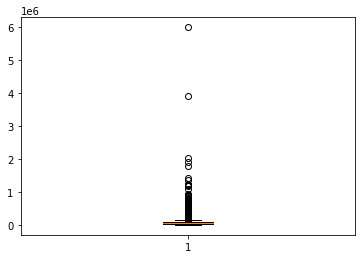

In [519]:
plt.boxplot(df.annual_inc)
plt.show()

#### checking the quantile data for removing the outliers

In [520]:
q_data = df.annual_inc.quantile([0.2,0.5, 0.75,0.90, 0.91,0.92,0.95,0.98,1])
q_data

0.20      38000.0
0.50      60000.0
0.75      83000.0
0.90     116672.4
0.91     120000.0
0.92     123996.0
0.95     142000.0
0.98     189996.0
1.00    6000000.0
Name: annual_inc, dtype: float64

In [521]:
### removing the outliers based on box plot and quantile data
df = df[df.annual_inc < 180000]

In [522]:
df.shape

(36632, 32)

### Data transformations
#### Change int_rate to float

In [523]:
df.int_rate = df.int_rate.apply(lambda x:x.strip('%')).astype('float')

#### Changing term data type to integer

In [524]:
 df.term =df.term.apply(lambda x: x.strip(' months')).astype('int')

#### Dropping columns which have unique values as from these we cannot draw any conclusion

In [528]:
df.drop(['initial_list_status','collections_12_mths_ex_med','policy_code','acc_now_delinq','chargeoff_within_12_mths','delinq_amnt','pub_rec_bankruptcies','tax_liens','pymnt_plan'],inplace=True,axis=1)

#### Apply transformation on emp_length such that < 1 year translates to 0 and 10+ years translate to 10 and change the data type of the feature column to integer

In [530]:
df.emp_length = df.emp_length.apply(lambda x: '0' if x == '< 1 year' else x)
df.emp_length = df.emp_length.apply(lambda x: '10' if x == '10+ years' else x)
df.emp_length = df.emp_length.str.extract('(\d+)')
df.emp_length = df.emp_length.astype('int')

 #### Change Charged off to Default and Fully Paid to Non-Default in loan_status feature column

In [532]:
df.loan_status.value_counts()

Fully Paid     31334
Charged Off     5298
Name: loan_status, dtype: int64

In [533]:
df.loan_status = df.loan_status.apply(lambda x: 'Default' if x == 'Charged Off' else 'Non-Default')

### Univariate and Segmented Univariate Analysis
#### Understanding the distribution of default vs non-default in the given data set

In [534]:
df.loan_status.value_counts()

Non-Default    31334
Default         5298
Name: loan_status, dtype: int64

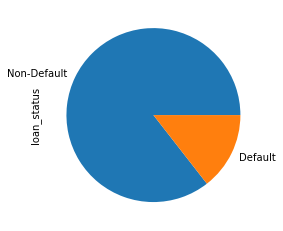

In [535]:
df.loan_status.value_counts().plot.pie()
plt.show()

#### Inference
-  Showing proportion of defaulters and non-defaulters

### Analysing the influence/impact of loan_amnt in profiling of default vs non-default
#### Binning the loan amounts feature column to understand which category of loan amount is more likely to be defaulted

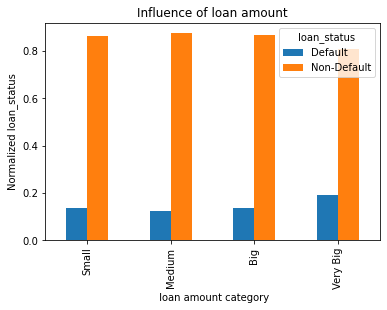

In [536]:
df["loan_amnt_cat"] = pd.qcut(df.loan_amnt, [0, 0.25, 0.5, 0.75, 1], labels=['Small', 'Medium', 'Big', 'Very Big'])
df.groupby('loan_amnt_cat')['loan_status'].value_counts(normalize=True).unstack().plot(kind='bar')
plt.title("Influence of loan amount")
plt.ylabel("Normalized loan_status")
plt.xlabel(" loan amount category")
plt.show()

#### Inference
- People offered higher loan amounts are more likely to default

### Analysing the influence/impact of grade in profiling of default vs non-default

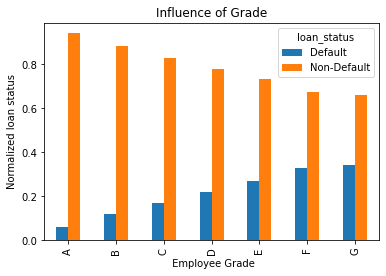

In [537]:
df.groupby('grade')['loan_status'].value_counts(normalize=True).unstack().plot(kind='bar')
plt.title("Influence of Grade")
plt.ylabel("Normalized loan status")
plt.xlabel(" Employee Grade")
plt.show()

#### Inference
- Defaulters are increasing with loans graded higher(A being small grade and G being higher grade)

### Analysing the influence/impact of term in profiling of default vs non-default

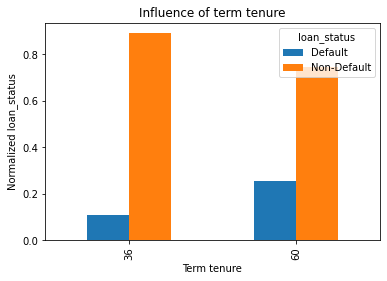

In [538]:
df.groupby('term')['loan_status'].value_counts(normalize=True).unstack().plot(kind='bar')
plt.title("Influence of term tenure")
plt.ylabel("Normalized loan_status")
plt.xlabel("Term tenure")
plt.show()

#### Inference
- Longer loan tenures have higher percentage of defaulters

### Analysing the influence/impact of verification_status in profiling of default vs non-default

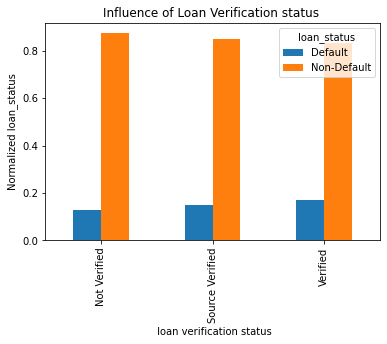

In [539]:
df.groupby('verification_status')['loan_status'].value_counts(normalize= True).unstack().plot(kind='bar')
plt.title("Influence of Loan Verification status ")
plt.ylabel("Normalized loan_status")
plt.xlabel(" loan verification status")
plt.show()

#### Inference
- The Verified loans tend to default higher as per the plot. Will revisit in the bivariate analysis

### Analysing the influence/impact of emp_length in profiling of default vs non-default
#### Binning the emp_length feature column to understand which category of emp_length is more likely to be defaulted

<AxesSubplot:xlabel='emp_length_bucket'>

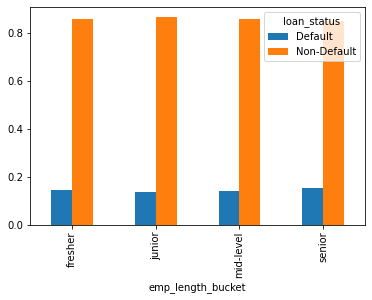

In [541]:
df['emp_length_bucket'] = pd.qcut(df.emp_length, [0,0.2,0.4,0.6,1], ["fresher","junior","mid-level","senior"])
df.groupby('emp_length_bucket')['loan_status'].value_counts(normalize = True).unstack().plot(kind='bar')

#### Inference
- Cannot draw conclusion from the above plots. We can check the influence in Bivariate analysis

### Analysing the influence/impact of int_rate in profiling of default vs non-default
#### Binning the int_rate feature column to understand which category of int_rate is more likely to be defaulted

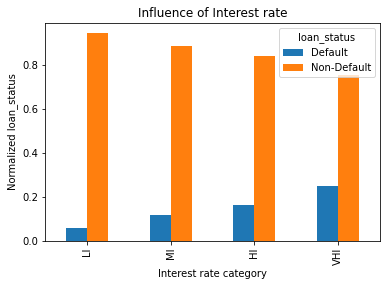

In [542]:
df['int_rate_bucket'] = pd.qcut(df['int_rate'], [0, 0.25, 0.5, 0.75, 1], labels=['LI', 'MI', 'HI', 'VHI'])
df.groupby('int_rate_bucket')['loan_status'].value_counts(normalize=True).unstack().plot(kind='bar')
plt.title("Influence of Interest rate")
plt.ylabel("Normalized loan_status")
plt.xlabel("Interest rate category")
plt.show()

#### Inference
- Loans offered at higher interest rate are more likely to default

### Analysing the influence/impact of dti in profiling of default vs non-default
#### Binning the dti feature column to understand which category of dti is more likely to be defaulted

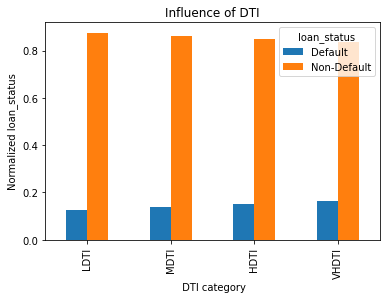

In [543]:
df['dti_bucket'] = pd.qcut(df['dti'], [0, 0.25, 0.5, 0.75, 1], labels=['LDTI', 'MDTI', 'HDTI', 'VHDTI'])
df.groupby('dti_bucket')['loan_status'].value_counts(normalize=True).unstack().plot(kind='bar')
plt.title("Influence of DTI")
plt.ylabel("Normalized loan_status")
plt.xlabel(" DTI category")
plt.show()

#### Inference
- People with Higher Debt to income ratio(DTI) are more likely to default

### Analysing the influence/impact of annual income in profiling of default vs non-default
#### Binning the annual_inc feature column to understand which category of income group is more likely to be defaulted

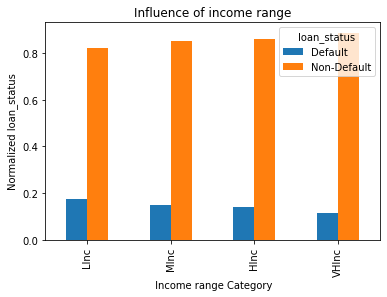

In [544]:
df['inc_bucket'] = pd.qcut(df['annual_inc'], [0, 0.25, 0.5, 0.75, 1], labels=['LInc', 'MInc', 'HInc', 'VHInc'])
df.groupby('inc_bucket')['loan_status'].value_counts(normalize=True).unstack().plot(kind='bar')
plt.title("Influence of income range")
plt.ylabel("Normalized loan_status")
plt.xlabel(" Income range Category")
plt.show()

#### Inference
- Employees with lower income groups are more likely to default


### Analysing the influence/impact of month of taking loan in profiling of default vs non-default
#### Binning the issue_d feature column to understand which month issued loan is more likely to be defaulted

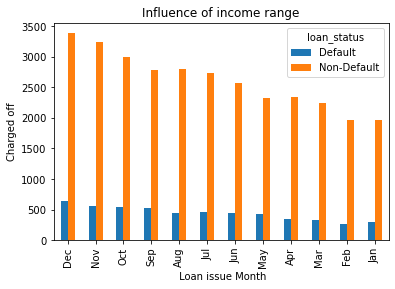

<Figure size 648x504 with 0 Axes>

In [545]:
df['issue_d_month'] = df['issue_d'].apply(lambda x: x[:3])
df.groupby('issue_d_month', sort=False)['loan_status'].value_counts().unstack().plot(kind='bar')
plt.title("Influence of income range")
plt.ylabel("Charged off")
plt.xlabel(" Loan issue Month")
plt.show()

#### Inference
- Loans issued during the course of the calendar year are more likely to default

### Analysing the influence/impact of purpose of taking loan in profiling of default vs non-default
#### Binning the issue_d feature column to understand which purpose is more likely to be defaulted

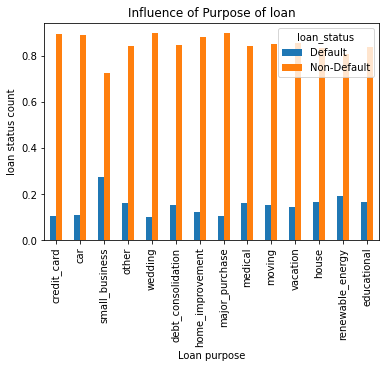

In [546]:
df.groupby('purpose',sort=False)['loan_status'].value_counts(normalize = True).unstack().plot(kind='bar')
plt.title("Influence of Purpose of loan")
plt.ylabel("loan status count")
plt.xlabel("Loan purpose")
plt.show()

#### Inference
- Certain Loan purposes(like small_business, medical, educational) showed more defaulters

### Analysing the influence/impact of home ownership in profiling of default vs non-default
#### Binning the issue_d feature column to understand which category of home ownership is more likely to be defaulted

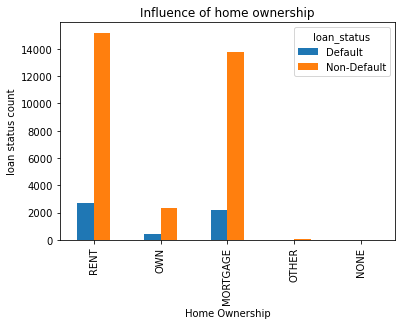

In [547]:
df.groupby('home_ownership',sort=False)['loan_status'].value_counts().unstack().plot(kind='bar')
plt.title("Influence of home ownership")
plt.ylabel("loan status count")
plt.xlabel("Home Ownership")
plt.show()

#### Inference
- Home ownership wth Rent/Mortage have higher defaulters. We will revisit in bivariate analysis

### Analysing the impact of addr_state in profiling of default vs non_default

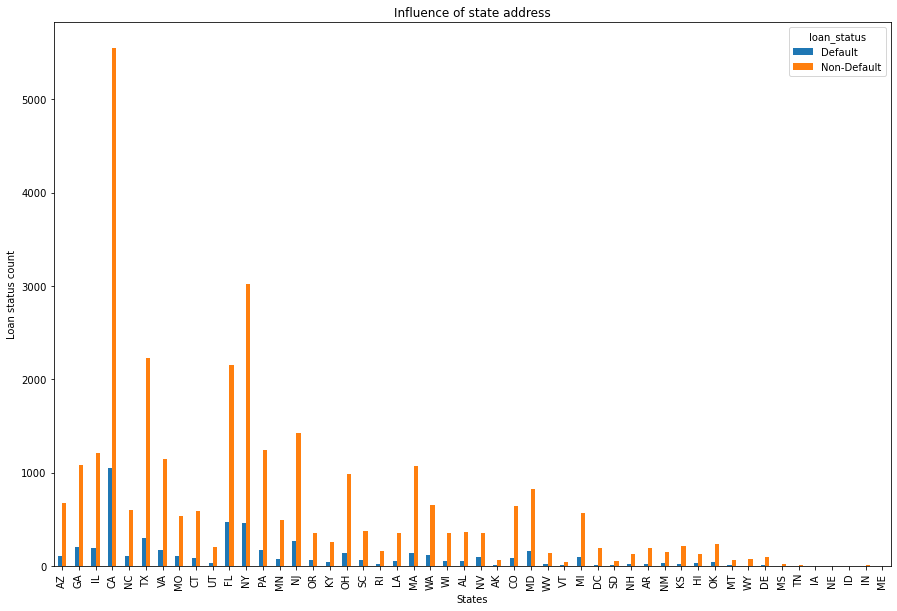

In [548]:
df.groupby('addr_state',sort=False)['loan_status'].value_counts().unstack().plot(kind='bar',figsize =(15,10))
plt.title("Influence of state address")
plt.ylabel("Loan status count")
plt.xlabel("States")
plt.show()

#### Inference
- CA state has higher defaulters

### BiVariate Analysis


#### Influence of Annual_inc and Grade on loan_status

#### Influence of loan_amnt and Verification status on loan_status

Text(0.5, 1.0, 'Influence of loan amount and Verification status')

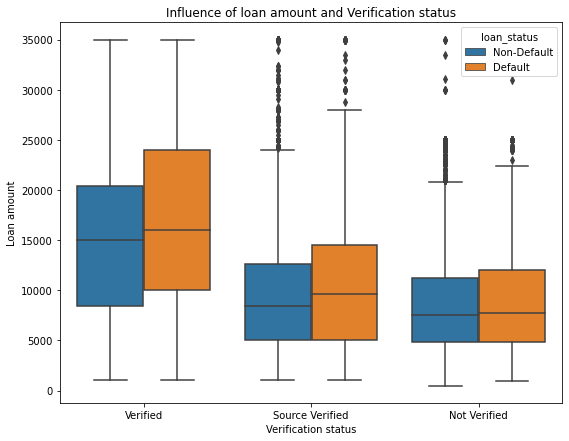

In [550]:
plt.figure(figsize=[9,7])
sns.boxplot(x='verification_status', y='loan_amnt', hue="loan_status", data=df)
plt.xlabel("Verification status")
plt.ylabel("Loan amount")
plt.title("Influence of loan amount and Verification status")

#### Inference
- Higher loan amount takers are more likely to default though the loans are verified

#### Influence of loan_amnt and int_rate_bucket on loan_status

Text(0.5, 1.0, 'Influence of loan amount and interest rate')

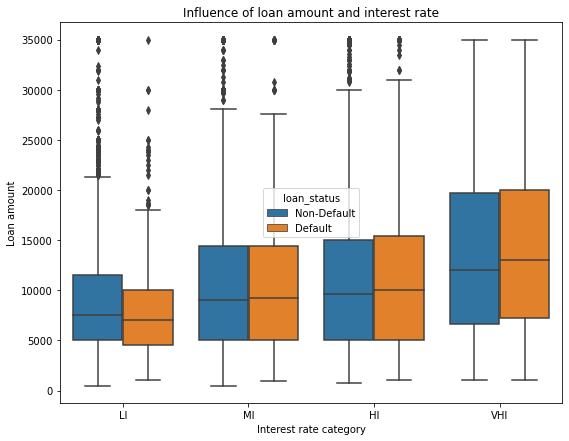

In [551]:
plt.figure(figsize=[9,7])
sns.boxplot(x='int_rate_bucket', y='loan_amnt', hue="loan_status", data=df)
plt.xlabel("Interest rate category")
plt.ylabel("Loan amount")
plt.title("Influence of loan amount and interest rate")

#### Inference
- Higher loan amounts taken at higher interest rates are more likely to default 

#### Influence of annual_income and home_ownership on loan_status

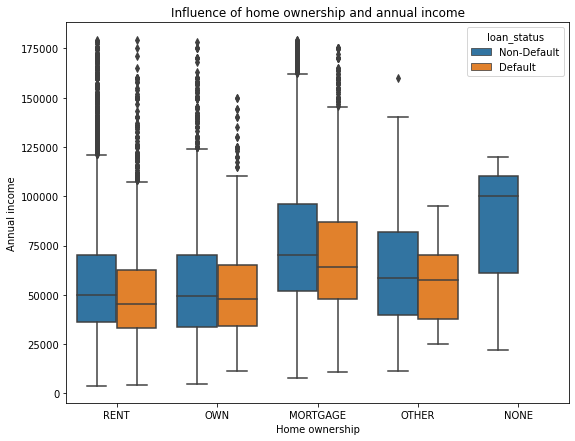

In [552]:
plt.figure(figsize=[9,7])
sns.boxplot(x='home_ownership', y='annual_inc', hue="loan_status", data=df)
plt.xlabel("Home ownership")
plt.ylabel("Annual income")
plt.title("Influence of home ownership and annual income")
plt.show()

#### Inference
- Employees with higher annual income but whose home ownership is MORTGAGED are more likely to default

#### Influence of loan_amount and employee length on loan_status

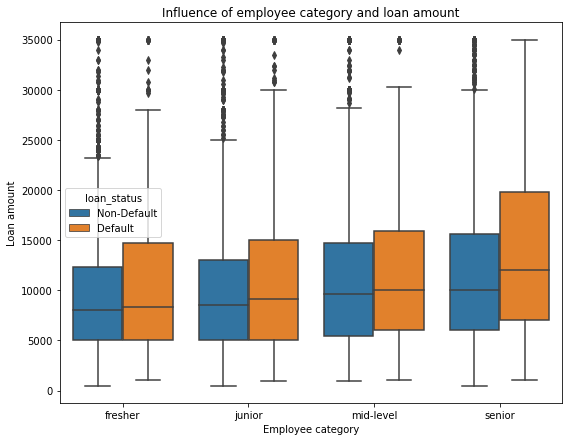

In [553]:
plt.figure(figsize=[9,7])
sns.boxplot(x='emp_length_bucket', y='loan_amnt', hue="loan_status", data=df)
plt.xlabel("Employee category")
plt.ylabel("Loan amount")
plt.title("Influence of employee category and loan amount")
plt.show()

#### Inference
- Senior employees offered higher loan amounts are more likely to default

#### Influence of annual income and employee length on loan_status

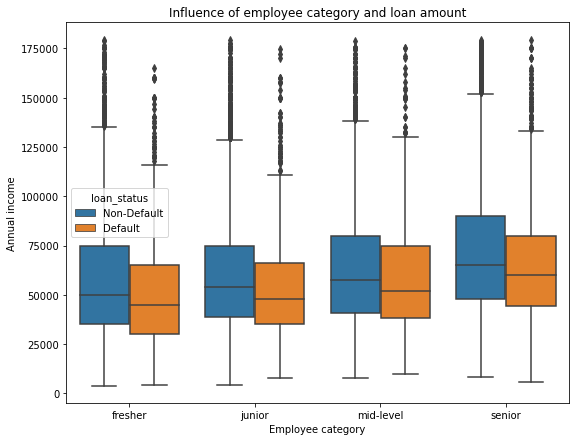

In [554]:
plt.figure(figsize=[9,7])
sns.boxplot(x='emp_length_bucket', y='annual_inc', hue="loan_status", data=df)
plt.xlabel("Employee category")
plt.ylabel("Annual income")
plt.title("Influence of employee category and loan amount")
plt.show()

#### Inference
- Seniors with higher annual income are more likely default

#### Influence of loan amount and income category on loan_status

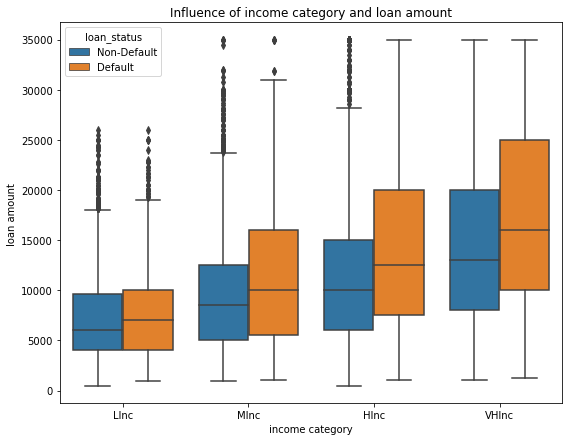

In [557]:
plt.figure(figsize=[9,7])
sns.boxplot(x='inc_bucket', y='loan_amnt', hue="loan_status", data=df)
plt.xlabel("income category")
plt.ylabel("loan amount ")
plt.title("Influence of income category and loan amount")
plt.show()

#### Inference
- Employees with very high income offered higher loan amount are more likely to default

#### Influence of loan amount and DTI on loan_status

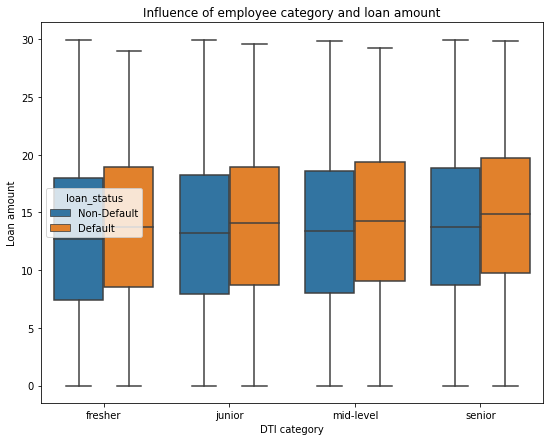

In [558]:
plt.figure(figsize=[9,7])
sns.boxplot(x='emp_length_bucket', y='dti', hue="loan_status", data=df)
plt.xlabel("DTI category")
plt.ylabel("Loan amount")
plt.title("Influence of employee category and loan amount")
plt.show()

#### Inference
- No clear inference can be drawn

#### Influence of loan amount and employee length on loan_status

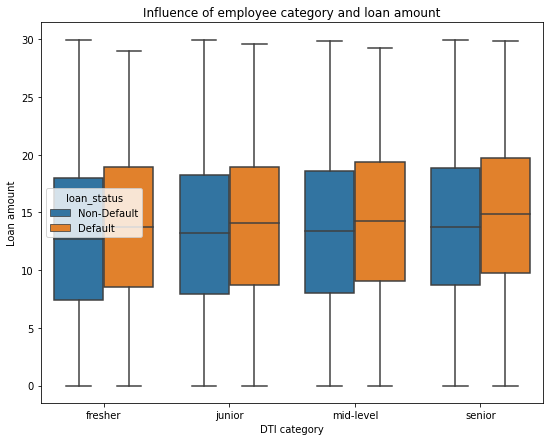

In [561]:
plt.figure(figsize=[9,7])
sns.boxplot(x='emp_length_bucket', y='dti', hue="loan_status", data=df)
plt.xlabel("DTI category")
plt.ylabel("Loan amount")
plt.title("Influence of employee category and loan amount")
plt.show()

#### Inference
- No clear inference can be drawn

#### Influence of annual income and dti on loan_status

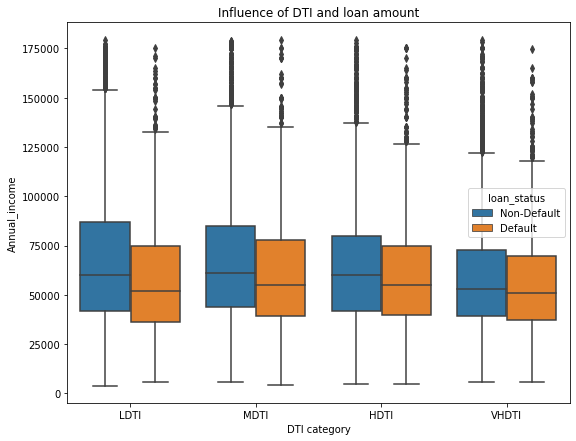

In [562]:
plt.figure(figsize=[9,7])
sns.boxplot(x='dti_bucket', y='annual_inc', hue="loan_status", data=df)
plt.xlabel("DTI category")
plt.ylabel("Annual_income")
plt.title("Influence of DTI and loan amount")
plt.show()

#### Inference
- No clear inference can be made here

#### Influence of loan_amount, term, interest rate on loan_status

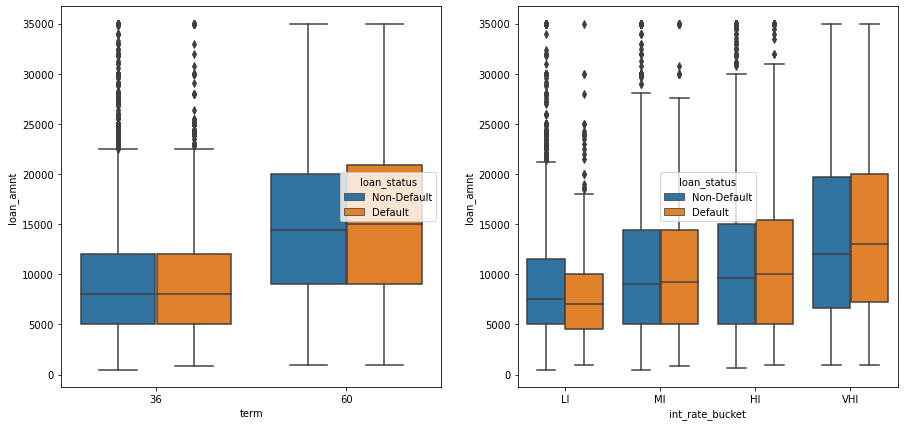

In [564]:
fig, axes = plt.subplots(1, 2,figsize =(15,7))
sns.boxplot(x='term', y='loan_amnt', hue="loan_status", data=df, ax = axes[0])
sns.boxplot(x='int_rate_bucket', y='loan_amnt', hue="loan_status", data=df, ax = axes[1])
plt.show()

#### Inference
- Higher loan amounts issued at higher interest rates for longer terms are more likely to be defaulted

### Recommendations

1. Reduce approving loans to those whose home ownership is mortgaged
2. Reduce interest rates for higher loan amounts taken for longer term
3. Reduce loan approvals given for small business purpose
4. Reduce loan approvals for individuals with higher Debt to Income ratio(DTI)
5. Reduce loan amounts disbursed to lower income groups
6. Reduce loan amounts disbursed for loans which are graded badly

The driver variables which are of utmost importance are interest_rate, home_ownership, loan_purpose, DTI, annual_income, term, loan_grade. Lending Club must consider the above driver variables carefully while disbursing loans to reduce the number of Charged Off/defaulted loans